# Spike Sorting Pipeline
## spikeinterface ver0.95

In [1]:
# Basic imports
import spikeinterface as si
import spikeinterface.extractors as se 
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.postprocessing as spost
import spikeinterface.qualitymetrics as sqm
import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
print(f"SpikeInterface version: {si.__version__}")
from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import generate_dummy_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb


import tdt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import glob
import os
import pickle

import warnings
warnings.simplefilter("ignore")

SpikeInterface version: 0.95.1


## Recording information

In [2]:
Mouse_ID = 'Eb43-3'
Session_ID = 'Eb43-3_No8_092322'
Block_ID = 'Block-1'
Task_Name = 'NoGo-2'

In [3]:
dataPath = glob.glob('/home/ysaito/Synology/Collab/with_Oisi/Ephys/01_Data/'+Mouse_ID+'/'+Session_ID+'/'+Block_ID)[0]
print('Data Path:',dataPath)
analysisPath = '/home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/'+Mouse_ID+'/'+Session_ID+'_analysis'+'/'+Block_ID
os.makedirs(analysisPath, exist_ok=True)
print('Analysis Path:',analysisPath)

Data Path: /home/ysaito/Synology/Collab/with_Oisi/Ephys/01_Data/Eb43-3/Eb43-3_No8_092322/Block-1
Analysis Path: /home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/Eb43-3/Eb43-3_No8_092322_analysis/Block-1


## Read TDT recording

In [4]:
# data = tdt.read_block(dataPath)
# data.info

In [5]:
# # read data
# fs = data['snips']['AWav']['fs'] #sampling frequency
# signals = []
# for ch in range(1,data['snips']['AWav']['chan'].max()+1):
#     signals.append(data['snips']['AWav'].data[np.where(data['snips']['AWav']['chan'].reshape(-1)==ch)[0],:].reshape(-1))
# signals=np.array(signals)*1000000 # gain x10000000

# Trig=data.epocs.Trig.onset
# Cue1=np.round((data.epocs.Cue1.onset-Trig)*fs).astype('int64')
# Cam1=np.round((data.epocs.Cam1.onset-Trig)*fs).astype('int64')
# Rew1=np.round((data.epocs.Rew1.onset-Trig)*fs).astype('int64')
# HLSA=np.round((data.epocs.HLSA.onset-Trig)*fs).astype('int64')
# HLSB=np.round((data.epocs.HLSB.onset-Trig)*fs).astype('int64')
# Lick=np.round((data.epocs.Lick.onset-Trig)*fs).astype('int64')
# TimeSeriesData = {'Ephys':signals, 'Cue1': Cue1, 'Cam1': Cam1, 'Rew1': Rew1, 'HLSA': HLSA, 'HLSB': HLSB, 'Lick': Lick, 'fs':fs}

In [6]:
# outPath_1 = analysisPath+'/01_Data'
# os.makedirs(outPath_1, exist_ok=True)

In [7]:
# f_name = outPath_1+'/TimeSeriesData.pkl'
# with open(f_name, mode='wb') as f:
#     pickle.dump(TimeSeriesData,f)

## Spike Sorting

In [8]:
outPath_1 = analysisPath+'/01_Data'
f_name = outPath_1+'/TimeSeriesData.pkl'
with open(f_name, mode='rb') as f:
    TimeSeriesData = pickle.load(f)

In [9]:
probePath = '/home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/00_Basic_Codes/Probe_File/4tet_16ch_0.prb'

In [10]:
recording = si.core.NumpyRecording(TimeSeriesData['Ephys'].T, sampling_frequency=TimeSeriesData['fs'], channel_ids=np.arange(0,16)+1)

In [11]:
probe = read_prb(probePath)

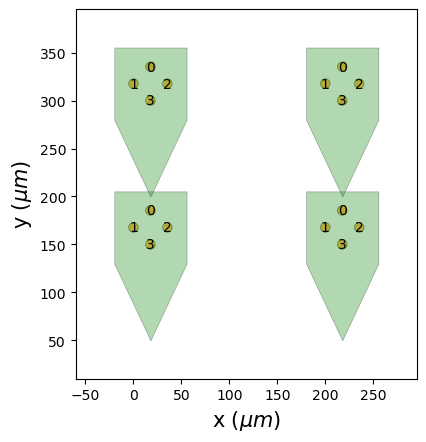

In [12]:
plot_probe_group(probe, same_axes=True, with_channel_index=True)

In [13]:
recording = recording.set_probegroup(probe)
recording_f = spre.bandpass_filter(recording, freq_min=600, freq_max=6000)
recording_cmr = spre.common_reference(recording_f, reference='global', operator='median')

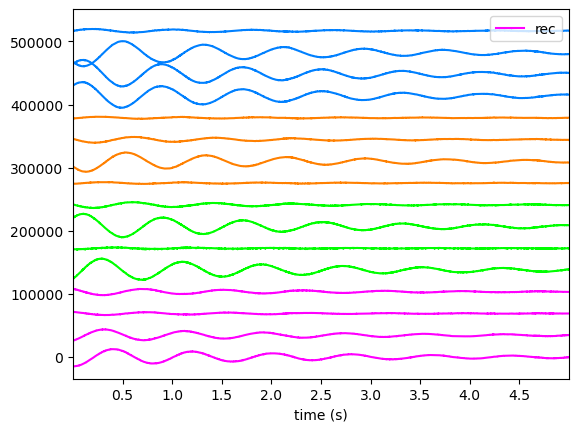

In [14]:
sw.plot_timeseries(recording, order_channel_by_depth=True,time_range=[0,5],color_groups=True)

26.77358592


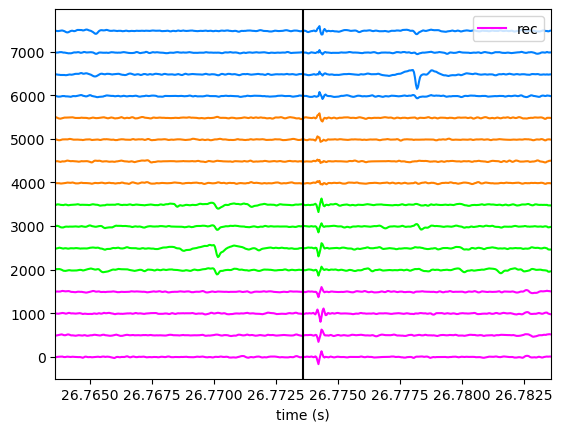

In [176]:
stim_id = 0
sw.plot_timeseries(recording_cmr, order_channel_by_depth=True,time_range=[(TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id]-0.01, (TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id]+0.01],color_groups=True)
plt.vlines((TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id], ymin=-1000, ymax=15000, color='k')
print((TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id])

26.77358592


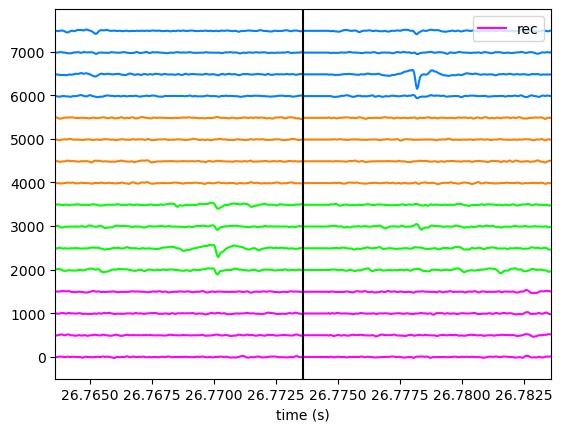

In [177]:
recording_rm = si.preprocessing.remove_artifacts(recording_cmr,  TimeSeriesData['HLSB'].tolist(), ms_before=0, ms_after=1, mode='zeros', fit_sample_spacing=1.0)
sw.plot_timeseries(recording_rm, order_channel_by_depth=True,time_range=[(TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id]-0.01, (TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id]+0.01],color_groups=True)
plt.vlines((TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id], ymin=-1000, ymax=15000, color='k')
print((TimeSeriesData['HLSB']/TimeSeriesData['fs'])[stim_id])

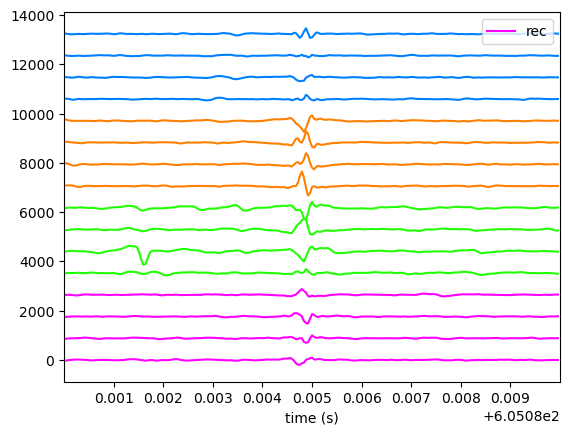

In [208]:
sw.plot_timeseries(recording_rm, order_channel_by_depth=True,time_range=[605.08, 605.09],color_groups=True)

In [17]:
job_kwargs = dict(n_jobs=20, chunk_duration="1s", progress_bar=True)

In [18]:
outPath_2= analysisPath + '/02_Preprocess'
# os.makedirs(outPath_2, exist_ok=True)
if os.path.isdir(outPath_2):
    recording_saved = si.load_extractor(outPath_2)
else:
    recording_saved = recording_rm.save(folder=outPath_2, **job_kwargs)

write_binary_recording with n_jobs = 20 and chunk_size = 24414


write_binary_recording:   0%|          | 0/1150 [00:00<?, ?it/s]

In [19]:
ss.kilosort2_5.Kilosort2_5Sorter.set_kilosort2_5_path('/home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/00_Basic_Codes/Spike_Sorter/Kilosort-2.5')

Setting KILOSORT2_5_PATH environment variable for subprocess calls to: /home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/00_Basic_Codes/Spike_Sorter/Kilosort-2.5


In [20]:
default_KS25_params = ss.kilosort2_5.Kilosort2_5Sorter.default_params()
default_KS25_params['n_jobs'] = 20

In [21]:
default_KS25_params

{'detect_threshold': 6,
 'projection_threshold': [10, 4],
 'preclust_threshold': 8,
 'car': True,
 'minFR': 0.1,
 'minfr_goodchannels': 0.1,
 'nblocks': 5,
 'sig': 20,
 'freq_min': 150,
 'sigmaMask': 30,
 'nPCs': 3,
 'ntbuff': 64,
 'nfilt_factor': 4,
 'NT': None,
 'do_correction': True,
 'wave_length': 61,
 'keep_good_only': False,
 'n_jobs': 20,
 'total_memory': None,
 'chunk_size': None,
 'chunk_memory': None,
 'chunk_duration': '1s',
 'progress_bar': True}

In [22]:
# run spike sorting on entire recording
sorting_KS25 = ss.run_sorter('kilosort2_5', recording_saved,
                             output_folder=analysisPath +'/03_results_KS2_5',
                             verbose=False, **default_KS25_params)

RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptj6eyf20h/script.sh
RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptevi91a47/script.sh


fatal: not a git repository (or any parent up to mount point /home/ysaito)
Stopping at filesystem boundary (GIT_DISCOVERY_ACROSS_FILESYSTEM not set).


RUNNING SHELL SCRIPT: /tmp/tmp_shellscriptdjboimp2/script.sh
RUNNING SHELL SCRIPT: /home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/Eb43-3/Eb43-3_No8_092322_analysis/Block-1/03_results_KS2_5/run_kilosort2_5.sh


In [23]:
import sys
sys.path.append('/home/ysaito/Synology/Collab/with_Oisi/Ephys/02_Analysis/00_Basic_Codes/postprocessing')
import load_kilosort, remove_double_count

In [24]:
params = dict()
params['within_unit_overlap_window'] = 0.000166
params['between_unit_overlap_window'] = 0.000166
params['between_unit_channel_distance'] = 4
params['output_dir'] = analysisPath +'/03_results_KS2_5'
params['sample'] = TimeSeriesData['fs']
spike_times_, spike_clusters_, spike_templates_, amplitudes_, templates_, channel_map_, pc_features_, pc_feature_ind_, template_features_ = load_kilosort.load_kilosort_data(analysisPath +'/03_results_KS2_5')
spike_times, spike_clusters, spike_templates, amplitudes, pc_features, template_features, overlap_matrix = \
remove_double_count.remove_double_counted_spikes(spike_times_, spike_clusters_, spike_templates_, amplitudes_, \
                                                 channel_map_, templates_, pc_features_, pc_feature_ind_,template_features_, \
                                                 params['sample'], params) 

Removing within-unit overlapping spikes...
931 spikes removed
Removing between-unit overlapping spikes...
18944 spikes_removed


In [189]:
phydir = analysisPath+'/03_results_KS2_5' + '/params.py'
!phy template-gui $phydir

19:54:41.771 [W] model:613            Unreferenced clusters found in spike_clusters (generally not a problem)
19:54:41.812 [W] model:655            Skipping spike waveforms that do not exist, they will be extracted on the fly from the raw data as needed.
20:01:34.825 [I] supervisor:702       Assigned 4491 spikes.
20:03:34.447 [I] supervisor:698       Undo cluster assign.


In [37]:
sorting_phy = se.PhySortingExtractor(analysisPath+'/03_results_KS2_5', exclude_cluster_groups=['noise', 'mua'])

unit ids S1: [ 0 34 59 63 67 71 73 75 80 82 86 88 93]
unit number S1: 13


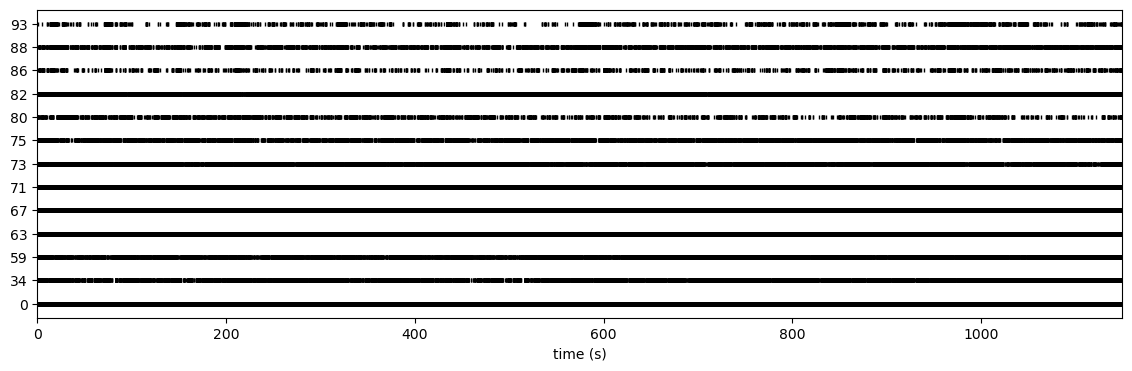

In [38]:
fig=plt.figure(figsize=(14,4))
sw.plot_rasters(sorting_phy, color='k', figure=fig, ax=None);
print(f'unit ids S1: {sorting_phy.get_unit_ids()}')
print(f'unit number S1: {len(sorting_phy.get_unit_ids())}')

In [196]:
# for i in range(len(TimeSeriesData['HLSB']/TimeSeriesData['fs'])):
#     fig=plt.figure(figsize=(8,4))
#     sw.plot_rasters(sorting_phy, color='k', figure=fig, ax=None);
#     plt.vlines(x=TimeSeriesData['HLSB'][i]/TimeSeriesData['fs'], ymin=-0.5, ymax=len(sorting_phy.get_unit_ids())+0.5, color='red')
#     plt.ylim(-0.5, ymax=len(sorting_phy.get_unit_ids())+0.5)
#     plt.xlim(TimeSeriesData['HLSB'][i]/TimeSeriesData['fs']-0.5,TimeSeriesData['HLSB'][i]/TimeSeriesData['fs']+1)

In [41]:
sorting_saved_phy = sorting_phy.save(folder=analysisPath +'/04_sorting_phy') 

## Feature extraction

In [108]:
recording_saved = si.load_extractor(outPath_2)
sorting = sorting_saved_phy

In [101]:
we = si.extract_waveforms(recording_saved, sorting, folder=analysisPath +'/05_waveforms', 
                          load_if_exists=False, overwrite=True, **job_kwargs)

Setting 'return_scaled' to False


extract waveforms memmap:   0%|          | 0/1150 [00:00<?, ?it/s]

In [109]:
waveforms0 = we.get_waveforms(unit_id=0)
print(f"Waveforms shape: {waveforms0.shape}")
template0 = we.get_template(unit_id=0)
print(f"Template shape: {template0.shape}")
all_templates = we.get_all_templates()
print(f"All templates shape: {all_templates.shape}")

Waveforms shape: (500, 170, 16)
Template shape: (170, 16)
All templates shape: (13, 170, 16)


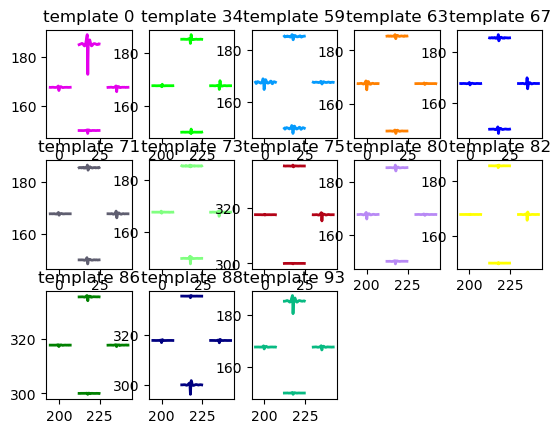

In [202]:
sw.plot_unit_templates(we, radius_um=50)

In [206]:
template_metrics = spost.calculate_template_metrics(we)
quality_metrics = sqm.compute_quality_metrics(we, sparsity=None, verbose=False, n_jobs=10)
unitFeature = pd.concat([template_metrics, qm], axis=1)
unitFeature['region'] = 'S1'
unitFeature['mouseID'] = Mouse_ID
unitFeature['sessionID'] = Session_ID
unitFeature['blockID'] = Block_ID

In [207]:
display(unitFeature)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_rate,isi_violations_count,amplitude_cutoff,region,mouseID,sessionID,blockID
0,0.000659,-0.137616,0.000143,4764592.241886,-182253.395365,34775,30.242666,1.00,39.548839,0.000634,0.001739,2,0.039280,S1,Eb43-3,Eb43-3_No8_092322,Block-1
34,0.000279,-1.089831,0.000209,358966.886583,-74503.800197,21808,18.965695,1.00,7.392939,0.053191,0.057398,66,0.000676,S1,Eb43-3,Eb43-3_No8_092322,Block-1
59,0.000483,-0.362343,0.000229,533148.476711,-98950.010443,9374,8.152257,1.00,9.759893,0.078514,0.015654,18,0.000518,S1,Eb43-3,Eb43-3_No8_092322,Block-1
63,0.00052,-0.321292,0.000201,433299.140571,-77302.933038,22455,19.528370,1.00,8.196417,0.198399,0.226983,261,0.003521,S1,Eb43-3,Eb43-3_No8_092322,Block-1
67,0.000598,-0.168731,0.00018,248928.407978,-38541.508581,27249,23.697553,1.00,7.860022,0.023746,0.040005,46,0.057820,S1,Eb43-3,Eb43-3_No8_092322,Block-1
71,0.000623,-0.225853,0.000217,224804.799203,-37010.285639,35480,30.855781,1.00,6.000320,0.054806,0.156540,180,0.000518,S1,Eb43-3,Eb43-3_No8_092322,Block-1
73,0.000258,-0.250241,0.000139,814993.519727,-40775.87353,14885,12.944991,1.00,8.034124,0.145314,0.073052,84,0.000518,S1,Eb43-3,Eb43-3_No8_092322,Block-1
75,0.000352,-0.123904,0.000152,732266.738449,-12684.505426,9279,8.069639,1.00,10.865330,0.057872,0.011306,13,0.000518,S1,Eb43-3,Eb43-3_No8_092322,Block-1
80,0.000774,-0.169242,0.00016,237381.716301,-35199.601556,3635,3.161239,1.00,8.376516,0.145040,0.004348,5,0.014518,S1,Eb43-3,Eb43-3_No8_092322,Block-1
82,0.000188,-0.42858,0.000135,989977.237353,-65985.792241,15791,13.732910,1.00,10.744640,0.047651,0.026960,31,0.011180,S1,Eb43-3,Eb43-3_No8_092322,Block-1


In [125]:
isi_viol_thresh = 0.2
our_query = f"isi_violations_rate < {isi_viol_thresh}"
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values

In [126]:
sorting_curated = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_curated.get_unit_ids())}")

Number of units before curation: 13
Number of units after curation: 12
